In [1]:
#LOADING LIBRARIES
%matplotlib inline
#%pylab inline

import pandas as pd
#import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
#import pylab
import sklearn
import time
import gc
import re

from sklearn import cross_validation, metrics, neighbors
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.grid_search import GridSearchCV
from scipy.stats import gaussian_kde
from sklearn.svm import SVC, NuSVC, LinearSVC, SVR, NuSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA, RandomizedPCA, TruncatedSVD
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.datasets import load_svmlight_file
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
#from xgboost.sklearn import XGBClassifier
from scipy import sparse
from multiprocessing import Pool


gc.enable()
np.random.seed(455)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)




In [2]:
#LOADING AND JOINING THE DATA

import os
import glob
#print (glob.glob("../kaggle_data/*.csv"))

df_train = pd.read_csv('../kaggle_data/train_users_2.csv')
df_test = pd.read_csv('../kaggle_data/test_users.csv')
labels = df_train['country_destination'].values


id_test = df_test['id']
count_rows_train = df_train.shape[0]
count_rows_test = df_test.shape[0]
print ("Total users in train: ",count_rows_train)
print ("Total users in test: ",count_rows_test)

df_test['country_destination'] = -1

#Creating a DataFrame with train+test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
#Filling nan
df_all = df_all.fillna(-1)

del df_test, df_train



Total users in train:  213451
Total users in test:  62096


16.0


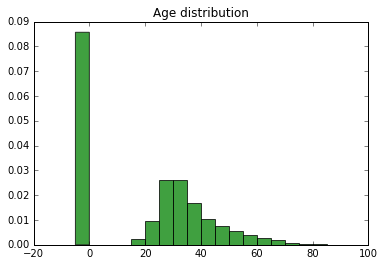

16.0


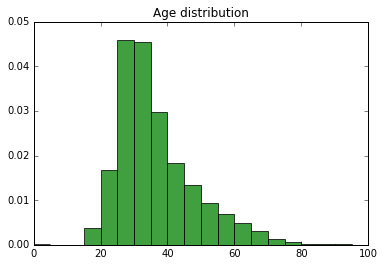

In [41]:
## Building age graphs

## Graph 1
plt_data = np.copy(df_all.age [df_all.age<100])

n_bins = np.arange(-5,100,5)

print (min(plt_data[plt_data>15]))
n, bins, patches = plt.hist(plt_data,bins = n_bins, normed=1, facecolor='green', alpha=0.75)
plt.title ("Age distribution")
plt.show ()


## Graph 2
plt_data = np.copy(df_all.age [df_all.age<100])

n_bins = np.arange(0,100,5)

print (min(plt_data[plt_data>15]))
n, bins, patches = plt.hist(plt_data,bins = n_bins, normed=1, facecolor='green', alpha=0.75)
plt.title ("Age distribution")
plt.show ()

In [234]:
#####Feature engineering#######

#date_account_created
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]


#timestamp_first_active
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]

#Age
av = np.copy(df_all.age.values)
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)
 

#Removing columns that won't be included into model

df_all = df_all.drop(['id', 'date_first_booking','country_destination','date_account_created',
                     'timestamp_first_active',], axis=1)

#print ("\nVar names:\n",df_all.columns.values)
print ("new columns created")


new columns created


In [235]:
age_gender_bkts = pd.read_csv('../kaggle_data/age_gender_bkts.csv')


## percent of population that is going to specific destination
age_gender_bkts["probs_total"] = age_gender_bkts["population_in_thousands"] / sum(age_gender_bkts["population_in_thousands"])
dfsum_by_country = age_gender_bkts.groupby(['country_destination','year'], as_index=False).sum()
dfsum_by_country = dfsum_by_country[["country_destination","year","population_in_thousands"]]
dfsum_by_country = dfsum_by_country.rename(columns = {"population_in_thousands": "sum_by_dest"})


dfsum_by_country
age_gender_bkts = pd.merge (age_gender_bkts,dfsum_by_country, on = ["country_destination"], how = "left")

## percent of demo that is heading to one of the destinations
age_gender_bkts["probs_by_country"] = age_gender_bkts["population_in_thousands"] / age_gender_bkts["sum_by_dest"]

age_gender_bkts = age_gender_bkts[["age_bucket", "country_destination","gender","probs_total","probs_by_country"]]


## Changing age column to interval
def age_search(x):
    ret = re.findall("[0-9]+",x)
    if len(ret)==1:
        ret = ret
        ret = ret + [""]
        
    return ret

#age_gender_bkts.age_bucket = list(map (lambda x: age_search(x), age_gender_bkts.age_bucket))

In [236]:
age_gender_bkts
av
##tt = pd.pivot_table(age_gender_bkts,index=['age_bucket','gender'], columns=['country_destination'], values = ['probs_total','probs_by_country'])

##print(age_gender_bkts.age_bucket[0])


#age_gender_bkts.age_bucket.apply(age_search, axis=1)

array([ -1.,  38.,  56., ...,  -1.,  -1.,  49.])

In [217]:
np.unique(age_gender_bkts.age_bucket)

array([['0', '4'], ['10', '14'], ['100'], ['15', '19'], ['20', '24'],
       ['25', '29'], ['30', '34'], ['35', '39'], ['40', '44'],
       ['45', '49'], ['5', '9'], ['50', '54'], ['55', '59'], ['60', '64'],
       ['65', '69'], ['70', '74'], ['75', '79'], ['80', '84'],
       ['85', '89'], ['90', '94'], ['95', '99']], dtype=object)

In [192]:
age_gender_bkts

age_bucket country_destination  gender  probs_total  probs_by_country
0        [100]                  AU    male     0.000001          0.000042
1     [95, 99]                  AU    male     0.000012          0.000376
2     [90, 94]                  AU    male     0.000064          0.001965
3     [85, 89]                  AU    male     0.000161          0.004932
4     [80, 84]                  AU    male     0.000272          0.008318
5     [75, 79]                  AU    male     0.000407          0.012457
6     [70, 74]                  AU    male     0.000567          0.017347
7     [65, 69]                  AU    male     0.000784          0.023994
8     [60, 64]                  AU    male     0.000869          0.026585
9     [55, 59]                  AU    male     0.000975          0.029846
..         ...                 ...     ...          ...               ...
410   [35, 39]                  US  female     0.014140          0.031839
411   [30, 34]                  US  female     0.014838          0.033411
412   [25, 29]                  US  female     0.015040          0.033866
413   [20, 24]                  US  female     0.015153          0.034122
414      [100]                  US    male     0.000018          0.000040
415   [95, 99]                  US    male     0.000157          0.000354
416   [90, 94]                  US    male     0.000739          0.001664
417   [15, 19]                  US  female     0.014438          0.032510
418   [85, 89]                  US    male     0.001968          0.004432
419   [80, 84]                  US    male     0.003336          0.007511

[420 rows x 5 columns]

In [191]:
# Splitting data into test and train
vals = df_all.values
X = vals[:count_rows_train]
le = LabelEncoder()
y = le.fit_transform(labels)   


X_test = vals[count_rows_train:]

print(labels)
print (y)

['NDF' 'NDF' 'US' ..., 'NDF' 'NDF' 'NDF']
[ 7  7 10 ...,  7  7  7]
